# Models Pipeline

We want to see how different models affect our dataset.

In [6]:
from preprocessing import load_dataset, split_dataset, grid_search, feature_interaction_polynomyal_degreee2, corresponding_features_interaction, corresponding_features_custom_interaction
from utilities import plot_grid_results, print_log
import models
import warnings

We define the generic parameters, to be used to split the dataset.

In [7]:
test_size = 0.2         # the ratio of the dataset we want to use as test set
stratify = True         # Whether we want the split to keep the same proportion between classes as the original dataset
k = 5                   # The number of folds for the (stratified) k fold 

warnings.filterwarnings('ignore')  # Warnings in the notebook

First of all, we load the dataset and we split it into training and test set (to be used only in the end).

We also apply different feature transformations to see if they improve our results.

In [8]:
# first, we load the dataset
X, y = load_dataset('./data/data.pkl')
# then, we split it
X_tr, y_tr, X_te, y_te = split_dataset(X, y, test=test_size, stratify=stratify)

# generate the dataset version with polynomyal features of degree 2
X_tr_poly = feature_interaction_polynomyal_degreee2(X_tr)

# generate the dataset version containing corresponding features interaction (the product)
# for example: (interest in music of x) * (interest in music of y)
X_tr_int_only = corresponding_features_interaction(X_tr, drop=True)

# generate the dataset version containing the result of a custom function that
# consider features interaction rewarding shared interests and penalizing unmatched interests
X_tr_custom_int_only = corresponding_features_interaction(corresponding_features_custom_interaction(X_tr), drop=True)

Now, we can start to try the grid search with different models, to see how it behaves.

Notice we want to have high __*recall*__ for class 'MATCH' (that is, we want to detect as many MATCH samples as possible). For this reason, we put recall as main metric for our grid search.

## Gaussian Mixture Modelling

### 1. No interactions, no PCA

In [9]:
# get pipeline 
pipe, grid = models.scaling(models.gmm)
# call grid_search
gmm_performance, gmm_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(gmm_performance)

Best model (according to recall): {'model__covariance_type': 'full', 'model__n_components': 1}
-----------------------------------------
Recall : 0.3746680080482897
Balanced accuracy: 0.6228210662034954
f1: 0.35394891663079353


### 2. Polynomial transformation, over sampling and PCA

In [11]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gmm)
# call grid_search
gmm_poly_performance, gmm_poly_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(gmm_poly_performance)

Best model (according to recall): {'model__covariance_type': 'tied', 'model__n_components': 8, 'pca__n_components': 66}
-----------------------------------------
Recall : 0.42682058160931396
Balanced accuracy: 0.5973587180123182
f1: 0.31646131590504745


### 3. Interactions only, over sampling and PCA

In [12]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gmm)
# call grid_search
gmm_int_performance, gmm_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(gmm_int_performance)

Best model (according to recall): {'model__covariance_type': 'full', 'model__n_components': 16, 'pca__n_components': 66}
-----------------------------------------
Recall : 0.09465476620406198
Balanced accuracy: 0.5167655669616452
f1: 0.12214164283374582


### 4. Custom interactions only, over sampling

In [13]:
# get pipeline 
pipe, grid = models.over_sampling(models.gmm)
# call grid_search
gmm_cint_performance, gmm_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(gmm_cint_performance)

Best model (according to recall): {'model__covariance_type': 'diag', 'model__n_components': 16}
-----------------------------------------
Recall : 0.6025842232884486
Balanced accuracy: 0.5539676397606819
f1: 0.2788496459837436


## Gradient Boosting Tree

### 1. No interactions, no PCA

In [14]:
# get pipeline 
pipe, grid = models.scaling(models.gradient_boosting)
# call grid_search
gb_performance, gb_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(gb_performance)

Best model (according to recall): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 6}
-----------------------------------------
Recall : 0.15645821157218
Balanced accuracy: 0.5521748087493596
f1: 0.21751534890387725


### 2. Polynomial transformation, over sampling and PCA

In [15]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gradient_boosting)
# call grid_search
gb_pt_performance, gb_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(gb_pt_performance)

Best model (according to recall): {'model__learning_rate': 0.05, 'model__max_depth': 8, 'model__min_samples_split': 6, 'pca__n_components': 25}
-----------------------------------------
Recall : 0.2689655172413793
Balanced accuracy: 0.5729540032728062
f1: 0.2762379148280086


### 3. Interactions only, over sampling and PCA

In [16]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gradient_boosting)
# call grid_search
gb_int_performance, gb_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(gb_int_performance)

Best model (according to recall): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 6, 'pca__n_components': 25}
-----------------------------------------
Recall : 0.07147866744593805
Balanced accuracy: 0.5093705712774337
f1: 0.10534147133097427


### 4. Custom interactions only, over sampling

In [17]:
# get pipeline 
pipe, grid = models.over_sampling(models.gradient_boosting)
# call grid_search
gb_cint_performance, gb_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(gb_cint_performance)

Best model (according to recall): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 6}
-----------------------------------------
Recall : 0.11899473991817651
Balanced accuracy: 0.5368962777093298
f1: 0.17327140050227524


## K-Nearest Neighbors

We run a grid search on the kNN model, trying values of k from 1 to 10. Since our data is highly dimensional, we expect such an algorithm to perform bad.

### 1. No interactions, no PCA

In [18]:
# get pipeline 
pipe, grid = models.scaling(models.knn)
# call grid_search
knn_performance, knn_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(knn_performance)

Best model (according to recall): {'model__n_neighbors': 3, 'model__weights': 'uniform'}
-----------------------------------------
Recall : 0.1669199298655757
Balanced accuracy: 0.5530070953127094
f1: 0.22315301556680867


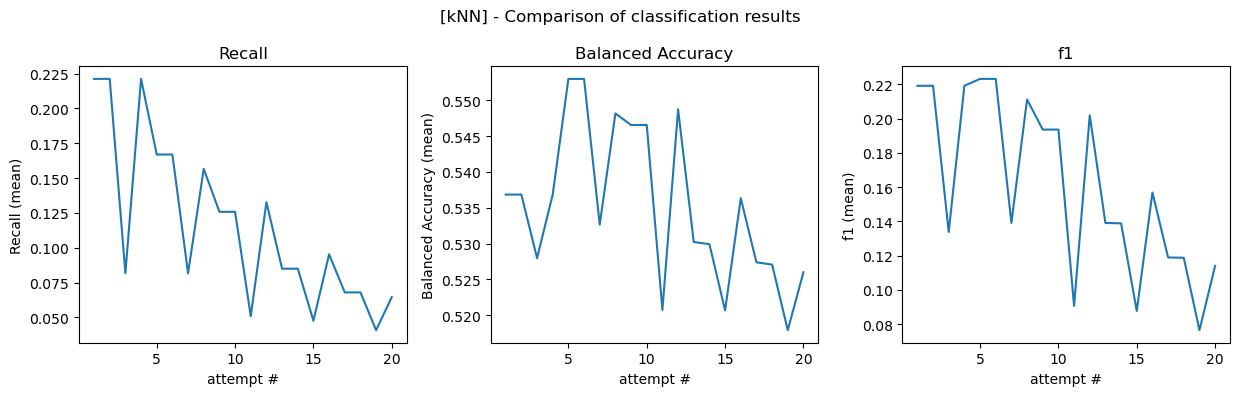

In [19]:
# Plot recall, balanced accuracy and f1 metric for every k in the range
plot_grid_results(knn_performance, 'kNN')

### 2. Polynomial transformation, over sampling and PCA

In [20]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_pt_performance, knn_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(knn_pt_performance)

Best model (according to recall): {'model__n_neighbors': 7, 'model__weights': 'distance', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.5614260666277031
Balanced accuracy: 0.609323470805226
f1: 0.3285162565588545


### 3. Interactions only, over sampling and PCA

In [21]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_int_performance, knn_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(knn_int_performance)

Best model (according to recall): {'model__n_neighbors': 1, 'model__weights': 'uniform', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.19731151373465808
Balanced accuracy: 0.5230056316726366
f1: 0.1963560214114538


### 4. Custom interactions only, over sampling

In [22]:
# get pipeline 
pipe, grid = models.over_sampling(models.knn)
# call grid_search
knn_cint_performance, knn_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(knn_cint_performance)

Best model (according to recall): {'model__n_neighbors': 5, 'model__weights': 'distance'}
-----------------------------------------
Recall : 0.588427819988311
Balanced accuracy: 0.5349465453917226
f1: 0.26754788523866724


### 5. Custom interactions only, over sampling, PCA

In [23]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_cint_pca_performance, knn_cint_pca_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(knn_cint_pca_performance)

Best model (according to recall): {'model__n_neighbors': 5, 'model__weights': 'distance', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.5950321449444769
Balanced accuracy: 0.586245592789267
f1: 0.3064898788613622


## Logistic Regression

Normal Logistic Regression does not converge. We try some strategies to reduce the dimensionality of our data.

### 1. Polynomial transformation, scaling

In [24]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_pt_performance, lr_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(lr_pt_performance)

Best model (according to recall): {'model__C': 10000}
-----------------------------------------
Recall : 0.3573933372296902
Balanced accuracy: 0.6096444022951748
f1: 0.33483231530533963


### 2. Interactions only, scaling

In [25]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_int_performance, lr_int_model  = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(lr_int_performance)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.48971361776738753
Balanced accuracy: 0.5511845626740369
f1: 0.2738810777032711


### 3. Interactions only, over sampling and PCA

In [26]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[20, 30, 66], model_f=models.logistic_regression)
# call grid_search
lr_int_pca_performance, lr_int_pca_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(lr_int_pca_performance)

Best model (according to recall): {'model__C': 10000, 'pca__n_components': 66}
-----------------------------------------
Recall : 0.07153711279953243
Balanced accuracy: 0.5115931655360214
f1: 0.10746685686372955


### 4. Custom interactions and scaling

In [27]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_cint_performance, lr_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(lr_cint_performance)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.4624780829924021
Balanced accuracy: 0.5520124883919642
f1: 0.2716746184828013


## Random Forest

### 1. Polynomial transformation, over sampling and scaling

In [28]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
rf_performance, rf_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(rf_performance)

Best model (according to recall): {'model__criterion': 'gini', 'model__min_samples_split': 5, 'model__n_estimators': 200}
-----------------------------------------
Recall : 0.14278199883109294
Balanced accuracy: 0.5575811376226006
f1: 0.22014875898420203


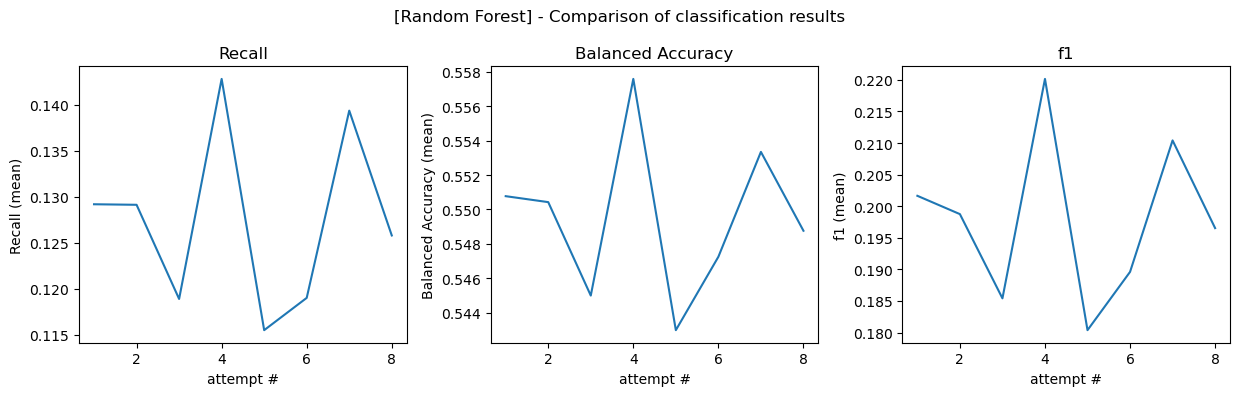

In [29]:
plot_grid_results(rf_performance, 'Random Forest')

### 2. Interactions over sampling and scaling

In [30]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
rf_int_performance, rf_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(rf_performance)

Best model (according to recall): {'model__criterion': 'gini', 'model__min_samples_split': 5, 'model__n_estimators': 200}
-----------------------------------------
Recall : 0.14278199883109294
Balanced accuracy: 0.5575811376226006
f1: 0.22014875898420203


### 3. Custom interactions and over sampling

In [31]:
# get pipeline 
pipe, grid = models.over_sampling(models.random_forest)
# call grid_search
rf_cint_performance, rf_cint_model  = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(rf_cint_performance)

Best model (according to recall): {'model__criterion': 'entropy', 'model__min_samples_split': 5, 'model__n_estimators': 100}
-----------------------------------------
Recall : 0.05447106954997079
Balanced accuracy: 0.5118533459380145
f1: 0.08789350695233047


## Support Vector Machines

### 1. Polynomial transformation, scaling

In [32]:
# get pipeline 
pipe, grid = models.scaling(models.svm)
# call grid_search
svm_performance, svm_model  = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(svm_performance)

Best model (according to recall): {'model__kernel': 'rbf'}
-----------------------------------------
Recall : 0.3982466393921683
Balanced accuracy: 0.6153089232922279
f1: 0.3453200079036801


### 2. Interactions only, over sampling and PCA

In [33]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.svm)
# call grid_search
svm_int_performance, svm_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(svm_int_performance)

Best model (according to recall): {'model__kernel': 'rbf', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.006838106370543542
Balanced accuracy: 0.5005908360759876
f1: 0.0131288673661555


### 3. Custom interactions and over sampling

In [34]:
# get pipeline 
pipe, grid = models.over_sampling(models.svm)
# call grid_search
svm_cint_performance, svm_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(svm_cint_performance)

Best model (according to recall): {'model__kernel': 'rbf'}
-----------------------------------------
Recall : 0.30964348334307423
Balanced accuracy: 0.515136009923346
f1: 0.216699433412508


## Best model selection and test
The model having the best performances in term of __recall__ is GMM without features interaction and PCA, the obtained result is not satisfactory.
Now we check its performances against the test set.

In [35]:
test_recall = gmm_model.score(X_te, y_te)

print("Recall on test set: ", test_recall)

Recall on test set: %f 0.6207388292815428
